<img src="https://github.com/Kesterchia/Institute-of-Data/blob/master/Project%202/Images/Kickstarter-Celebrates-10-Years-of-Funding.jpg?raw=true" width="420" height="420"> 

# Introduction

Kickstarter is an online crowdfunding platform for entrepreneurs to obtain a "kick-start" in capital for their project ideas. 

Individual project ideas are uploaded onto the Kickstarter website, where consumers can view information about the project including production plans, budgets and monetary goals. Each project must then reach it's respective monetary goal before it's deadline, which can be anywhere between 1 to 60 days from the project's creation.

Kickstarter adopts an "all-or-nothing" approach to funding, which means that if a project doesn't hit it's goal by the deadline, it receives no funds and is deemed a failed project. 

# About this project: 

### Estimating the number of backers needed to have a successful kickstarter campaign

This project aims to deliver some insights into how much support from backers a kickstarter project would need to have a decent chance of success. The end goal is to develop a tool that would allow an entrepreneur to have a reasonable estimate of how different expected numbers of backers can affect his chances of success.

# Dataset information:


### Source

Data obtained from: https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv


### Content

This dataset contains about 400,000 rows of data collected on crowdfunding projects hosted on Kickstarter.com.

Columns should be self explanatory. 

### Acknowledgements

Data is collected from Kickstarter Platform


In [1]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

import category_encoders as ce

import joblib

%matplotlib inline



In [2]:
#Read in data (CSV)

df = pd.read_csv('./Data/ks-projects-201801.csv', index_col = 'ID')

#Note: Remember to read in ID as the index column!

#Check the size of the dataset:

print('No. of rows:', df.shape[0])
print('No. of columns:',df.shape[1])

No. of rows: 378661
No. of columns: 14


In [3]:
#Check first few rows of data:

df.head(3)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


# Part 1: Data cleaning

### Cleaning the target variable:

In [4]:
#Check the unique values of the target variable

df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

Kickstarter uses an all-or-nothing funding approach, so complete projects are either successful (completedly funded) or failed (partially funded). I only want to include completed projects with an outcome, therefore cancelled, suspended and undefined project outcomes will be removed.

In [5]:
#Only keep projects that are either failed or successful

df = df[df['state'].isin(['failed','successful'])]

#Checking target variable counts again

df['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

### Cleaning null values:

In [6]:
#Check null values
df.isnull().sum()

name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

There are not many null values (only 210 out of ~400,000), so we drop the rows with null values

In [7]:
df = df.dropna()

#Check null values again:

df.isnull().sum()

name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

# Part 2: EDA and feature engineering

In this section I do some exploratory data analysis on the features, and also create a new feature for subsequent models. I start with some univariate analyses and end off with multivariate analyses.

### Target variable (State):

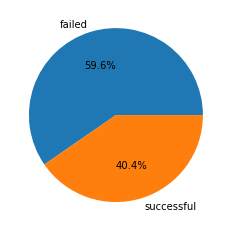

In [8]:
#Show the failure rate of projects

plt.pie(x = df['state'].value_counts(),
        labels = df['state'].value_counts().index,
        autopct='%1.1f%%')

plt.show()

About 60% of all projects posted to Kickstarter don't reach their goals. We convert the 'failed' and 'successful' states to dummy variables:

In [9]:
#Convert column values to 1's and 0's by creating dummy columns:

df = pd.get_dummies(data = df,
                    columns = ['state'])

#We only have to keep one column:

df = df.drop('state_failed', axis = 1)


### Project category:

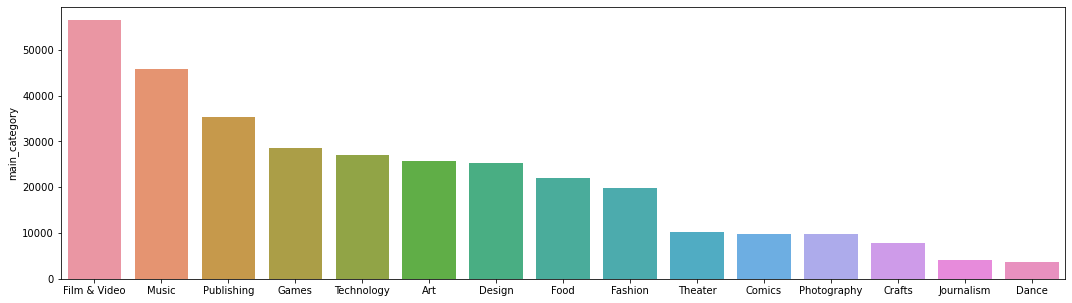

In [10]:
#Check the typical categories for projects

plt.figure(figsize = (18,5))

sns.barplot(x =  df['main_category'].value_counts().index,
            y =  df['main_category'].value_counts())

Seems like project distribution is pretty balanced, a good variety of all kinds of projects except for the last few

### Currency that project is paid in:

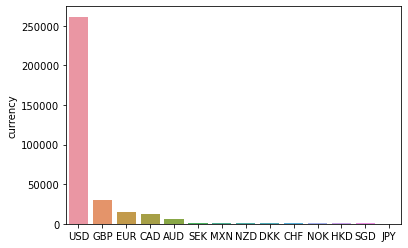

In [11]:
sns.barplot(x = df['currency'].value_counts().index,
            y = df['currency'].value_counts())

In [12]:
df['currency'].value_counts()

USD    261358
GBP     29453
EUR     14357
CAD     12370
AUD      6616
SEK      1509
MXN      1411
NZD      1274
DKK       926
CHF       652
NOK       582
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

Most of the projects are paid in USD, doesn't seem like an important variable. Also it can act as a proxy for the 'Country' variable so we will not include it.

### Deadlines and launch dates of projects:

In [13]:
df[['deadline','launched']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 1000002330 to 999988282
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   deadline  331462 non-null  object
 1   launched  331462 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


Datatypes are classified as objects. They should be classified as time data instead:

In [14]:
#Converting datatypes:

df = df.astype({'deadline':'datetime64',
                'launched':'datetime64'
               }
              )

#See if conversion is successful:

df[['deadline','launched']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 1000002330 to 999988282
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   deadline  331462 non-null  datetime64[ns]
 1   launched  331462 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.6 MB


#### Feature engineering a new column: 

Having less time before the deadline might reasonably affect project success. We will create a new column to depict that:

In [15]:
#Create a new column showing time between project launch to deadline

time_to_deadline = df['deadline'] - df['launched']
time_to_deadline[:5]

ID
1000002330   58 days 11:47:32
1000003930   59 days 19:16:03
1000004038   44 days 23:39:10
1000007540   29 days 20:35:49
1000014025   34 days 10:21:33
dtype: timedelta64[ns]

In [16]:
#Only keep the number of days to make it simpler, also as int dtype:

time_to_deadline_days = time_to_deadline.dt.days

df['Days to deadline'] = time_to_deadline_days

df['Days to deadline'][:5]

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000014025    34
Name: Days to deadline, dtype: int64

In [17]:
#Note: Time delta information is stored in pandas in nanoseconds (10^-9).

In [18]:
#Example:

print(time_to_deadline[1:2])
print('\t')
print('Value:', time_to_deadline[1:2].values)
print('\t')
print('Value converted to days:',time_to_deadline[1:2].values /1000 /1000 /1000 #Convert to seconds 
                                                                          /60 #to Minutes
                                                                          /60 #to Hours
                                                                          /24)#to Days

ID
1000003930   59 days 19:16:03
dtype: timedelta64[ns]
	
Value: [5166963000000000]
	
Value converted to days: [59]


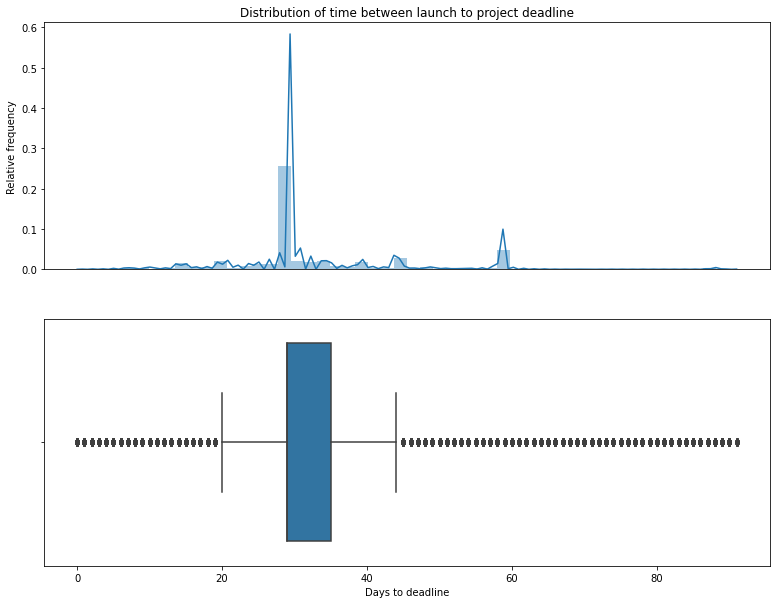

In [19]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13,10))


sns.distplot(df['Days to deadline'],
             ax = ax[0])

sns.boxplot(df['Days to deadline'],
            ax = ax[1])

ax[0].xaxis.set_visible(False)
ax[0].set_title('Distribution of time between launch to project deadline')
ax[0].set_ylabel('Relative frequency')

plt.show()

In [20]:
#Definitely high variation in time to deadline, with most projects falling between 20 to 40 days

### Number of project backers:

In [21]:
df['backers'].describe()

count    331462.000000
mean        116.456315
std         965.732911
min           0.000000
25%           2.000000
50%          15.000000
75%          63.000000
max      219382.000000
Name: backers, dtype: float64

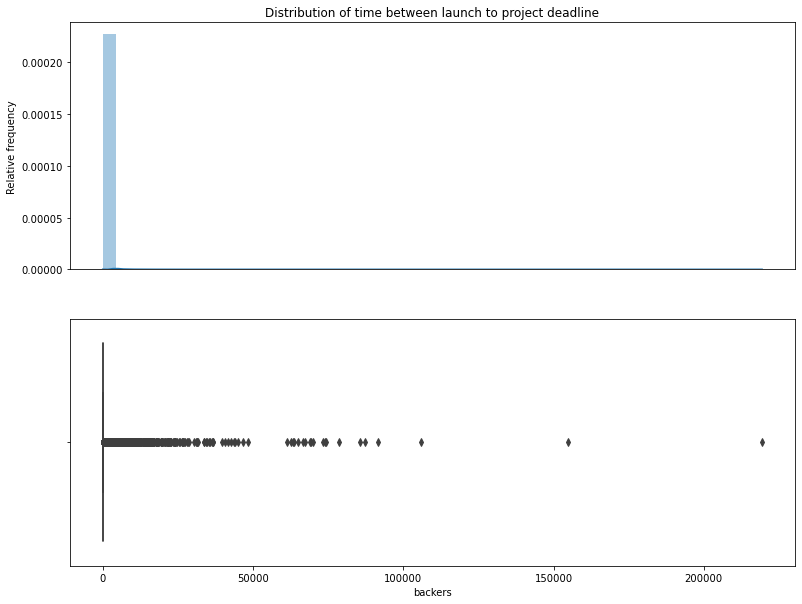

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13,10))

sns.distplot(df['backers'],
             ax = ax[0])

sns.boxplot(df['backers'],
            ax = ax[1])

ax[0].xaxis.set_visible(False)
ax[0].set_title('Distribution of time between launch to project deadline')
ax[0].set_ylabel('Relative frequency')
plt.show()

Most projects are actually very close to 0 backers - This makes sense since the failure rate is about 60%

I will also remove rows with extremely high amounts of backers (above 98th percentile), since its reasonable to assume these projects will almost certainly be successful

In [23]:
#Removing top 2 percentiles of data:

df = df[df['backers'] < np.quantile(df['backers'],0.98)]

In [24]:
#Check the new values:

df['backers'].describe()

#Maximum value is now 908 instead of 219,000 

count    324831.000000
mean         57.207332
std         113.427217
min           0.000000
25%           2.000000
50%          14.000000
75%          58.000000
max         908.000000
Name: backers, dtype: float64

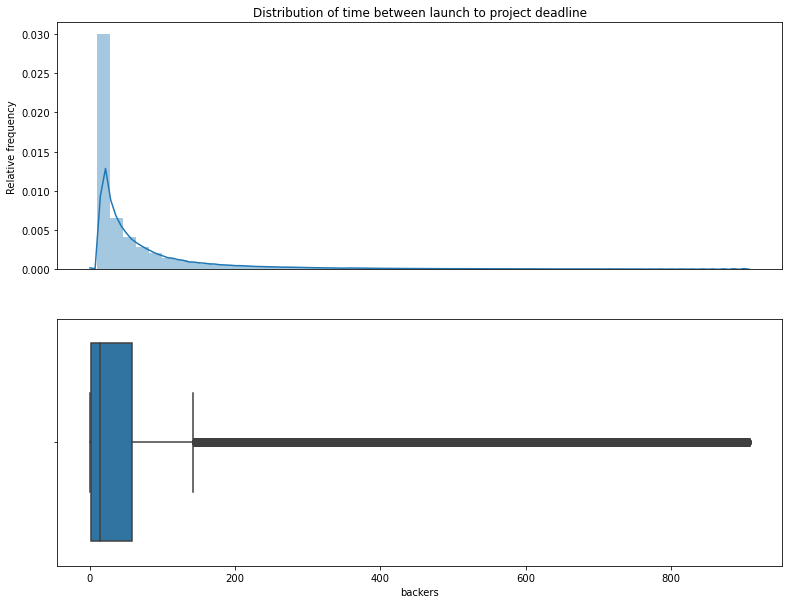

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13,10))


sns.distplot(df['backers'],
             ax = ax[0])

sns.boxplot(df['backers'],
            ax = ax[1])

ax[0].xaxis.set_visible(False)
ax[0].set_title('Distribution of time between launch to project deadline')
ax[0].set_ylabel('Relative frequency')

plt.show()

In [26]:
# Distribution still looks very skewed, but at least it's not as extreme as before

### Project goals (measured in real USD value):

In [27]:
df['usd_goal_real'].describe()

count    3.248310e+05
mean     4.110891e+04
std      1.119136e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

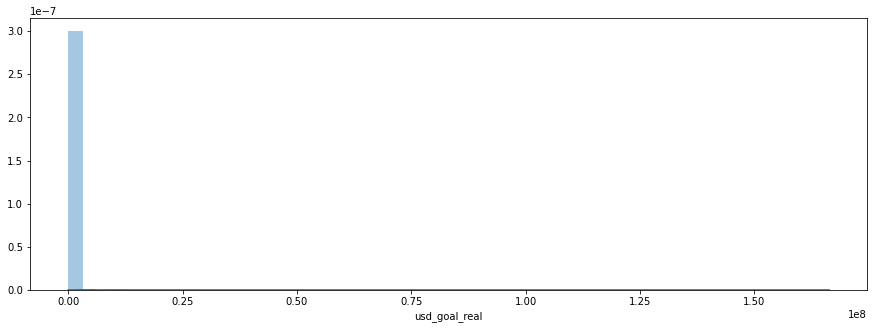

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

sns.distplot(df['usd_goal_real'], 
             ax = ax)

In [29]:
#Remove both top and bottom 1 percentile: 

df = df[
         (df['usd_goal_real'] > np.quantile(df['usd_goal_real'],0.01)) & 
         (df['usd_goal_real'] < np.quantile(df['usd_goal_real'],0.99))
                        ]

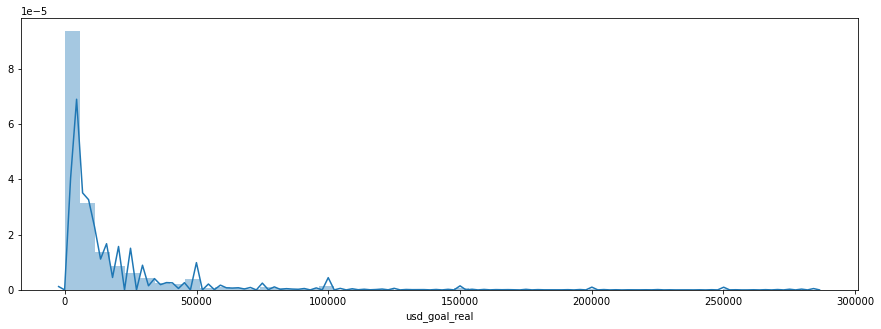

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

sns.distplot(df['usd_goal_real'], 
             ax = ax)

### Final amount pledged for project:

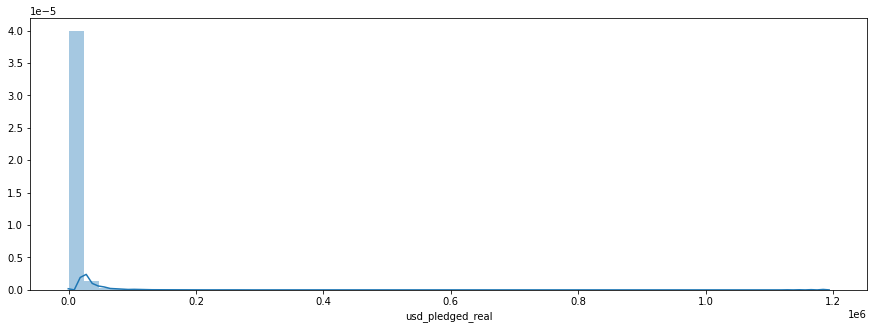

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

sns.distplot(df['usd_pledged_real'], 
             ax = ax)

In [32]:
#Remove bottom and top 1 percentiles:

df = df[
         (df['usd_pledged_real'] > np.quantile(df['usd_pledged_real'],0.01)) & 
         (df['usd_pledged_real'] < np.quantile(df['usd_pledged_real'],0.99))
                        ]

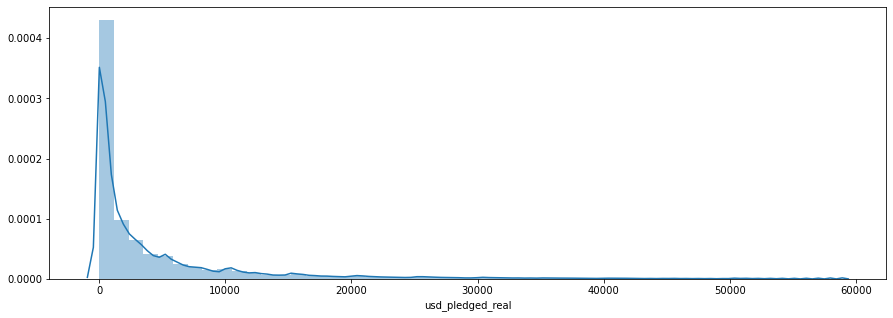

In [33]:
#Checking the distribution again

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

sns.distplot(df['usd_pledged_real'], 
             ax = ax)

### Checking 'country':

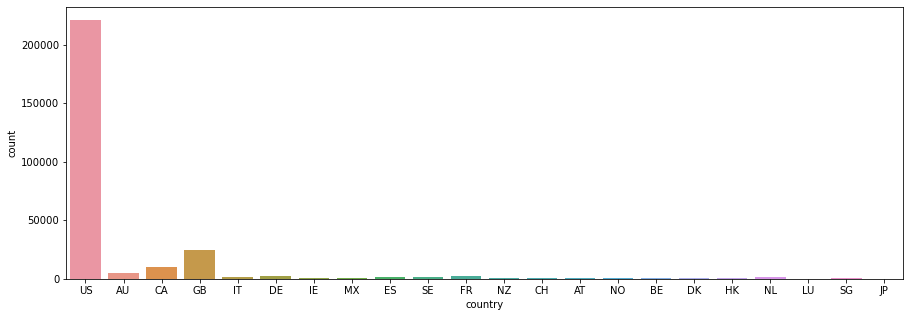

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

sns.countplot(df['country'], 
             ax = ax)



In [35]:
df['country'].value_counts()

US    221032
GB     24729
CA      9889
AU      5339
DE      2709
FR      1993
NL      1885
IT      1811
ES      1453
SE      1217
MX      1091
NZ      1066
DK       750
IE       562
CH       494
NO       461
BE       428
HK       389
AT       384
SG       379
LU        48
JP        21
Name: country, dtype: int64

In [36]:
#It seems like most of the projects come from the US
#There are a decent number of projects coming from other countries except JP and LU, so I will drop those countries

df = df[~df['country'].isin(['LU','JP'])]

# Multivariate EDA

In [37]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import f_oneway

In [38]:
numericals = df.select_dtypes(include = ['float64', 'int64'])
categoricals = df.select_dtypes(include = ['object'])

### Constructing a pairplot to see associations between explanatory variables:

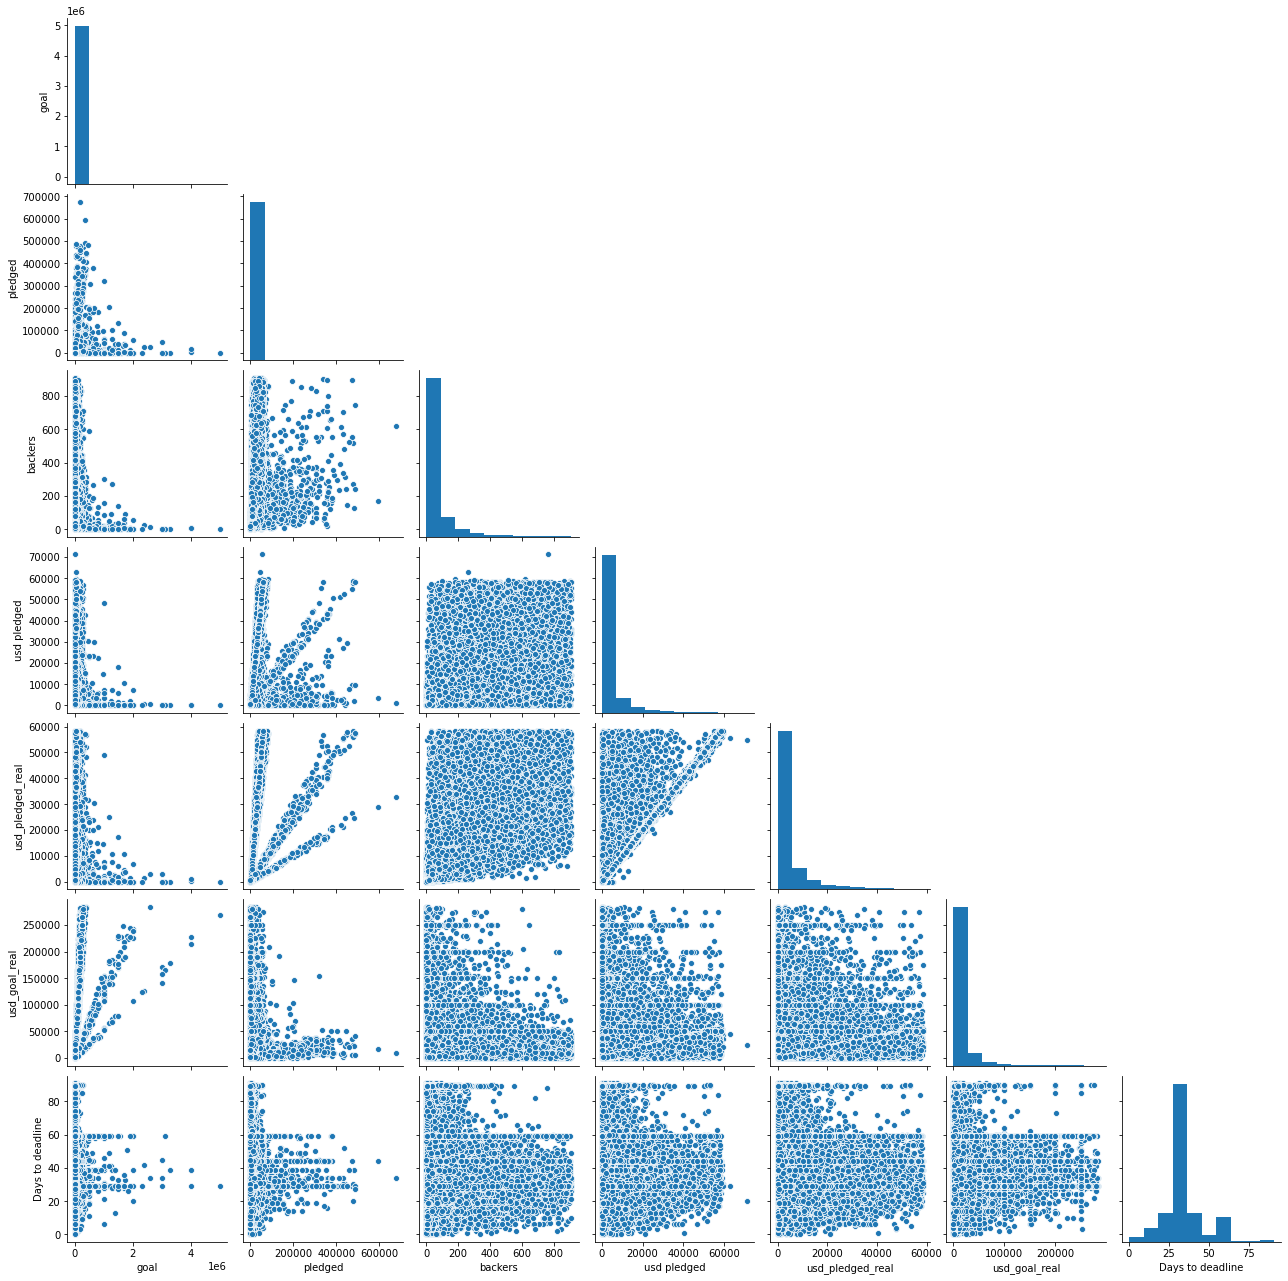

In [39]:
g = sns.pairplot(numericals)

for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
    g.axes[i, j].set_visible(False)

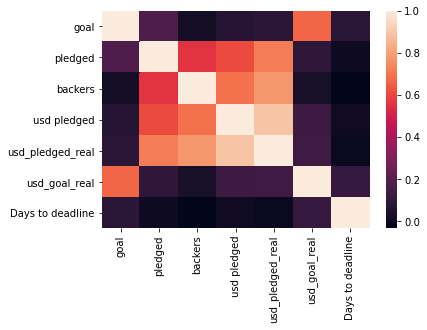

In [40]:
sns.heatmap(numericals.corr())

mask = np.zeros_like(numericals.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

The variables 'pledged', 'usd_pledged_real' and 'usd_pledged' are strongly linearly correlated.

The variables 'goal' and 'usd_goal_real' are perfecly linearly correlated.

We should therefore remove some of the variables to reduce multicollinearity in our models

### Conducting an ANOVA test between numerical variables and target:

ANOVA (Analysis of Variance) tests try to discern if there is a relationship between a categorical variable and a numerical variable.

In [41]:
pd.DataFrame(data = f_classif(numericals, df['state_successful']),
             columns = numericals.columns,
             index = ['F-statistic','p-value'])

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,Days to deadline
F-statistic,7760.297116,29837.77847,67108.013803,48822.213955,62358.737529,17811.159909,4551.028177
p-value,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


The F-statistics and p-values for every variable is extremely significant, so these variables should be included in prediction model. We want variables that would be available to an entrepreneur at the time of his project launch, so we exclude the variables relating to the amount pledged.

### Conducting a Chi-squared test between categorical variables and target:

Chi-squared tests, also known as goodness of fit tests, investigate whether two categorical variables are associated with each other. 

In [42]:
from scipy.stats import chi2_contingency

chi2_values = []
p_values = []

for column in categoricals.columns[:-1]:
    contingency = pd.crosstab(df[column], df['state_successful'])

    chi2_val, p_value, degrees_of_freedom, expected = chi2_contingency(contingency)
    
    chi2_values.append(chi2_val)
    p_values.append(p_value)
    
data = list(zip(categoricals.columns, chi2_values, p_values))
pd.DataFrame(data = data,
             columns = ['Variable','Chi squared value','p-value'])

,Variable,Chi squared value,p-value
0,name,276800.438043,0.413757
1,category,26457.831429,0.000000
2,main_category,15931.197884,0.000000
3,currency,1683.267470,0.000000


The chi-squared tests for all variables except project name return significant results as expected, indicating a strong association with the target variable. 

### Variables picked as features so far:

Main category of project (  χ2 = 18098, p = 0)

Country of project origin (  χ2 = 2214, p = 0)

Combining launch date and deadline into 'Time before deadline' (F = 4466, p = 0)

Project goal measured in real USD value (F = 18543, p = 0) 

No. of backers (F = 90328, p = 0)

### Variables not picked:

Currency (May act as a proxy for the country variable)

Name (No association with project success with p = 0.35)



# Step 2.5: Scaling data and PCA

We first scale the numerical data. Much of the numerical data exhibit high positive skews, so we will use a robust scaler instead of a standard scaler.

In [43]:
#Reset indexes to prevent some future issues with concatenation:

X = df[['main_category','Days to deadline','usd_goal_real','backers','country']].reset_index(drop = True)
y = df['state_successful'].reset_index(drop = True)

In [44]:
#We use a robust scaler because most of our variables are pretty skewed

#Robust scalers use median and IQR instead of the standard mean and S.D.

from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler()

X_numerical = X.drop(['main_category','country'], axis = 1)

scaler.fit(X_numerical)

scaled_X = scaler.transform(X_numerical)

scaled_X = pd.DataFrame(scaled_X, columns = X_numerical.columns)

### Attempting Principle Component Analysis

Now with scaling done, we can attempt to do some Principle Component Analysis (PCA) to see if we can reduce the dimensionality:

In [45]:
from sklearn.decomposition import PCA

#We put n_components as default None so we don't remove any components yet

pca_components = PCA(n_components = None).fit(scaled_X)

#We can see how much variance each Principal Component explains:
for i, variance in enumerate(pca_components.explained_variance_ratio_):
    print('Variance explained by PC{}: {}'.format(i+1, variance))

Variance explained by PC1: 0.42723205033864964
Variance explained by PC2: 0.33281859186196033
Variance explained by PC3: 0.23994935779939003


Each component explains a decent amount of variance, so it might not be suitable to reduce dimensionality any further. Therefore we will not use PCA for this purpose.

Now that both numerical and categorical columns are ready, I can concatenate them:

In [46]:
#After data scaling, I can concatenate my categorical and numerical variables:

X = pd.concat([scaled_X, X[['main_category','country']]],
               join = 'outer', 
               axis = 1
             )

X.head()

,Days to deadline,usd_goal_real,backers,main_category,country
0,5.000000,2.108054,-0.079365,Film & Video,US
1,2.500000,3.372886,-0.269841,Film & Video,US
2,0.000000,0.000000,-0.301587,Music,US
3,0.833333,3.794497,3.238095,Food,US
4,-1.666667,-0.337289,-0.063492,Food,US


In [47]:
#Double check the shape:

X.shape

(278061, 5)

# Step 2.5:  Creating clusters and encoding variables

### Looking for patterns by creating clusters based on numeric data (K-Means):

In [48]:
%%time

#Attempting to obtain optimal no. of clusters k:

from sklearn.cluster import KMeans

inertias = []

for k in range(3,10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_X)
    inertias.append(kmeans.inertia_)
    

Wall time: 22.8 s


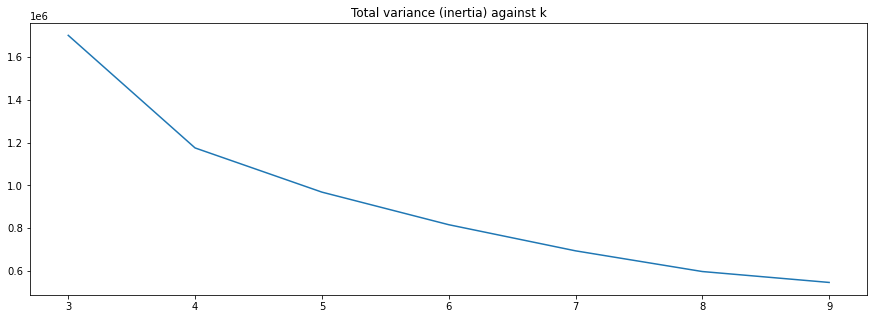

In [49]:
#Plot an inertia vs k graph to visualize the 'elbow':

plt.figure(figsize = (15,5))

sns.lineplot(x = range(3,10),
             y = inertias)

plt.title('Total variance (inertia) against k')
plt.show()

The graph seems to have a distinct elbow at k=4, therefore that value will be chosen as the k-value for clustering

In [50]:
#Creating 4 clusters in the dataset:

kmeans = KMeans(n_clusters = 4)

kmeans_predictions = kmeans.fit_predict(scaled_X)

#Add cluster to features table

X['Cluster (k=4)'] = kmeans_predictions

In [51]:
#Check that clusters are added:

X.head()

,Days to deadline,usd_goal_real,backers,main_category,country,Cluster (k=4)
0,5.000000,2.108054,-0.079365,Film & Video,US,3
1,2.500000,3.372886,-0.269841,Film & Video,US,3
2,0.000000,0.000000,-0.301587,Music,US,1
3,0.833333,3.794497,3.238095,Food,US,0
4,-1.666667,-0.337289,-0.063492,Food,US,1


# Step 3: Implementing models

### Before implementing models, we must first encode the categorical variables:

In [52]:
#Using get_dummies would use One-hot encoding, but with high cardinality the data would end up with a high dimension

print('For One-hot encoding:')
print('\t')
print('No. of rows:', pd.get_dummies(X).shape[0])
print('No. of columns:', pd.get_dummies(X).shape[1])

pd.get_dummies(X).head(1)

For One-hot encoding:
	
No. of rows: 278061
No. of columns: 39


,Days to deadline,usd_goal_real,backers,Cluster (k=4),main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_HK,country_IE,country_IT,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,5.0,2.108054,-0.079365,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [53]:
#Using a binary encoder instead might help reduce the dimensionality
#This involves converting to numerical labels, then converting the numbers into binary form

import category_encoders as ce

encoder = ce.BinaryEncoder(cols = ['main_category','country','Cluster (k=4)'])

print('For binary encoding:')
print('\t')
print('No. of rows:', encoder.fit_transform(X).shape[0])
print('No. of columns:', encoder.fit_transform(X).shape[1])

X = encoder.fit_transform(X)

X.head(1)

For binary encoding:
	
No. of rows: 278061
No. of columns: 17


,Days to deadline,usd_goal_real,backers,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,country_0,country_1,country_2,country_3,country_4,country_5,Cluster (k=4)_0,Cluster (k=4)_1,Cluster (k=4)_2
0,5.0,2.108054,-0.079365,0,0,0,0,1,0,0,0,0,0,1,0,0,1


Now that the target and explanatory variables are encoded, we can implement our models to predict project success. We first begin by splitting the data into training and test sets.

In [54]:
# Splitting the data:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

### Establishing a baseline classifier:

In [55]:
#Establish a baseline dummy model to have a benchmark for model accuracy:

from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy = 'stratified')

baseline.fit(X_train,y_train)

baseline_predictions = baseline.predict(X_test)

print('Baseline model accuracy:',accuracy_score(y_test,baseline.predict(X_test)))

Baseline model accuracy: 0.5056287529560489


### Logistic regression

In [56]:
%%time
%%capture

#Measure how long the model takes to fit

#Try a Logistic Regression model:


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logmodel = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = {'solver':['sag','lbfgs'],
                                      'C': [0.01,0.1,0.5,1]# Sag is gradient descent
                                     },                    # Lbfgs calculates second derivatives without actually calculating it
                        cv = 5 
                       )
logmodel.fit(X_train,y_train.astype(int))

#Generate predictions:

logmodel_predictions = logmodel.predict(X_test)

Wall time: 1min 51s


In [57]:
print('Best parameters for Logistic Regression:', logmodel.best_params_)

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}


### Support vector machines


In [58]:
%%time 

from sklearn.svm import SVC
import joblib

# svc = SVC().fit(X_train,y_train) #Can't use GridSearchCV, it takes a billion years


#Save model so I don't have to re-fit the model every time I restart the notebook

# joblib.dump(svc, 'svc_model.joblib')


#Opening model from saved file and generate predictions:

svc = joblib.load('./Models/svc_model.joblib')

svc_predictions = svc.predict(X_test)

Wall time: 1min 38s


### Decision Tree

In [59]:
%%time
%%capture

from sklearn.tree import DecisionTreeClassifier

tree = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'criterion':["gini", "entropy"],
                                 },
                    cv = 5 #Default 5-fold CV
                   )
tree.fit(X_train,y_train)

#Generate predictions:

tree_predictions = tree.predict(X_test)

Wall time: 6.05 s


In [60]:
print('Criterion choice for decision tree:',tree.best_params_)

Criterion choice for decision tree: {'criterion': 'entropy'}


### Random forest (Ensemble of decision trees) (Removed because forest.joblib was >700MB)

In [61]:
%%time

from sklearn.ensemble import RandomForestClassifier

# forest = GridSearchCV(RandomForestClassifier(),
#                    param_grid = {'n_estimators' : [100,200,300],
#                                  'max_features' : ['auto'] #Default
#                                 }                                               
#                     )
# forest.fit(X_train,y_train)

# joblib.dump(forest, 'forest_model.joblib')

# forest = joblib.load('./Models/forest_model.joblib')
                     
#Generate predictions

# forest_predictions = forest.predict(X_test)

Wall time: 125 ms


In [62]:
# forest.best_params_

### Adaboost classification (Forest of stumps)

In [63]:
%%time

from sklearn.ensemble import AdaBoostClassifier

# adaboost_cv = GridSearchCV(estimator = AdaBoostClassifier(),
                               #param_grid = {'n_estimators' : [50,100,200],
                                             #'learning_rate' : [0.2,0.5,0.8,1.0]})

# adaboost_cv.fit(X_train,y_train)

# Save Adaboost classifier object:

# joblib.dump(adaboost_cv, 'adaboost_model.joblib')


#Load adaboost model:

adaboost_cv = joblib.load('./Models/adaboost_model.joblib')

#Generate predictions:
adaboost_cv_predictions = adaboost_cv.predict(X_test)

Wall time: 2.56 s


In [64]:
print('Best parameters for Adaboost Classifier:', adaboost_cv.best_params_)

Best parameters for Adaboost Classifier: {'learning_rate': 0.2, 'n_estimators': 200}


# 4: Evaluating models

In [65]:
%%time

#Calculate a few metrics for the models and put them in a table:

from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, plot_roc_curve,classification_report

model_names = ['Logistic Regression', 'Support vector machines', 'Decision tree', 'Adaboost', 'Baseline (Stratified)']

models = [logmodel, svc, tree, adaboost_cv, baseline]

predictions = [logmodel_predictions, svc_predictions, tree_predictions, adaboost_cv_predictions, baseline_predictions]

training_accuracy_scores = [model.score(X_train,y_train) for model in models]

test_accuracy_scores = [accuracy_score(y_test,predictions[i]) for i,model in enumerate(models)]

precisions = [precision_score(y_test,predictions[i]) for i,model in enumerate(models)]

recalls = [recall_score(y_test, predictions[i]) for i,model in enumerate(models)]

f1_scores = [f1_score(y_test,predictions[i]) for i,model in enumerate(models)]

cross_validated = ['Yes','No','Yes','Yes','Yes','No']

Wall time: 3min 13s


In [66]:
datapoints = zip(model_names, training_accuracy_scores, test_accuracy_scores, precisions, recalls, f1_scores, cross_validated)

pd.DataFrame(data = datapoints,
             columns = ['Model','Training accuracy', 'Test accuracy', 'Precision', 'Recall','F1_score', 'Cross validated?'])

,Model,Training accuracy,Test accuracy,Precision,Recall,F1_score,Cross validated?
0,Logistic Regression,0.904713,0.902987,0.916169,0.858214,0.886245,Yes
1,Support vector machines,0.879291,0.877214,0.931574,0.778325,0.848082,No
2,Decision tree,0.988427,0.890193,0.880075,0.869054,0.874530,Yes
3,Adaboost,0.899705,0.897298,0.931120,0.828021,0.876549,Yes
4,Baseline (Stratified),0.507203,0.505291,0.438253,0.438177,0.438215,Yes


Based on the results, the Adaboost model has the highest test accuracy and also has an above average precision and recall performance. Therefore we will be choosing the Adaboost model over the rest.

### Plotting confusion matrices for each model

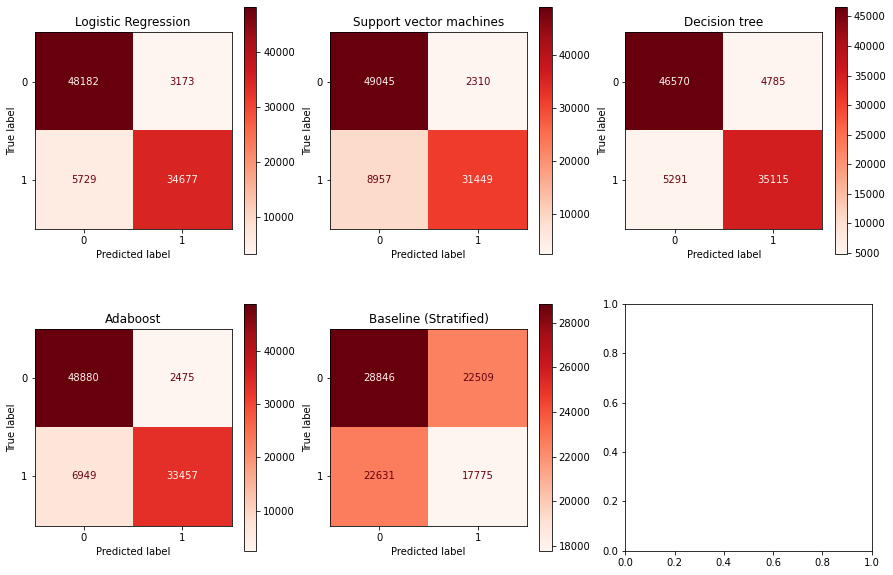

In [67]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))

for model, axis, modelname in zip(models,axes.flatten(), model_names):
    plot_confusion_matrix(estimator = model,
                          X = X_test,
                          y_true = y_test,
                          cmap = 'Reds',
                          ax = axis,)
    axis.set_title(modelname)
    axis.grid(False)

### Plotting ROC curves for each model

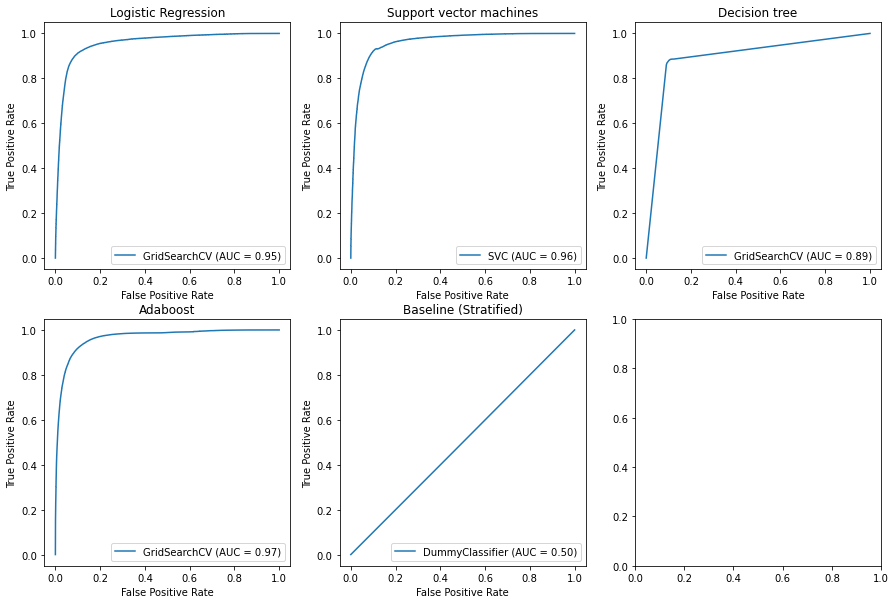

In [68]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))

for model, axis, modelname in zip(models,axes.flatten(), model_names):
    plot_roc_curve(estimator = model,
                          X = X_test,
                          y = y_test,
                          ax = axis,)
    axis.set_title(modelname)

# 5: Making a tool to estimate how many backers a project would need

The aim here is to make a simple tool to provide someone that is planning to launch a project with some idea of how many backers he would need to be successful.

In [69]:
#Predict_proba function returns the probability of 0 and 1 as outcomes

sample = X.sample(1)

#To access probability that the project is successful:

print('Project probability of success:', adaboost_cv.predict_proba(sample)[0][1])

Project probability of success: 0.5163421502692017


### Defining a function to return success probabilities:

In [70]:
#First create a function that returns the success probability (using logistic regression)

def predict_project_success(data, model):

    #Scale data

    X_numerical = data[['Days to deadline','usd_goal_real','backers']]
    scaled_X = pd.DataFrame(scaler.transform(X_numerical), columns = X_numerical.columns)

    scaled_X

    #Cluster data

    clusters = pd.DataFrame(kmeans.predict(scaled_X), columns = ['Cluster (k=4)'])

    # Concatenate categorical and numerical variables

    X = pd.concat([scaled_X, 
                   clusters, 
                   data[['main_category','country']].reset_index(drop = True)
                  ],
                   axis = 1,
                    )

    #Encode X

    encoded_X = encoder.transform(X)

    encoded_X

    #Generate prediction probability

    return (model.predict_proba(encoded_X)[0][1]) #Probability estimate that project is successful

In [71]:
#Take a sample of the data:

sample = df.sample(1)
sample

,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_successful,Days to deadline
ID,,,,,,,,,,,,,,,
772485272,Skye Light's Music Video,Pop,Music,USD,2017-09-17,500.0,2017-08-18 04:59:30,500.0,6,US,50.0,500.0,500.0,1,29


In [72]:
#Predicted success probability of sample:

print('Predicted success probability:',predict_project_success(sample,adaboost_cv))

Predicted success probability: 0.47754555019473754


### Subsequently, defining a second function that generates a plot of project success probability against no. of backers:

In [73]:
#Define function to generate a plot of expected data

def plot_success_graph(model,days, goal, category, country, max_backers):
    
    
    '''
    This function plots a graph of an estimate of the project's success given an arbitrary amount of backers.
    
    Arguments:
    
    days: Total number of days from the project's launch to the deadline of completion.
    
    goal: The monetary goal of the project in USD.
    
    category: The category that the project falls under. Must be in: ['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts',
    'Games','Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography','Technology', 'Dance', 'Journalism']
    
    country: Country of the project's origin. Must be in: ['GB', 'US', 'CA', 'AU', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE', 'FR',
       'NZ', 'CH', 'AT', 'NO', 'BE', 'DK', 'HK', 'NL', 'SG']
       
    max_backers: Maximum backers limit for model to estimate till (Model starts with 0, step size = 20).
    
    '''
    
    
    data = pd.DataFrame(columns = ['Days to deadline','usd_goal_real','main_category','country'],
                        data = [[days,goal,category,country]])
    probabilities = []
    for i in np.arange(0,max_backers,5):
        data.loc[:,'backers'] = i
        probability_success = predict_project_success(data,model)
        probabilities.append(probability_success)
    
    plt.figure(figsize = (20,5))
    
    sns.set_style('darkgrid')
    
    sns.lineplot(y = probabilities,
                 x = np.arange(0,max_backers,5))
    
    plt.xlabel('No. of backers', fontdict = {'fontsize':15})
    plt.xticks(np.arange(0,max_backers,step = 25))
    
    plt.ylabel('Probability of success', fontdict = {'fontsize':15})
    
    plt.title('Probability of project success by backers', fontdict = {'fontsize':15})
    
    plt.show()


### Some examples of the function being used: 

Here we try some examples of the defined functions on some hypothetical data. 

For the sake of these examples, pretend the user was an entrepreneur who was looking to launch a game-related project in New Zealand, with a crowdfunding timeline of 50 days and a goal of $10,000 USD:

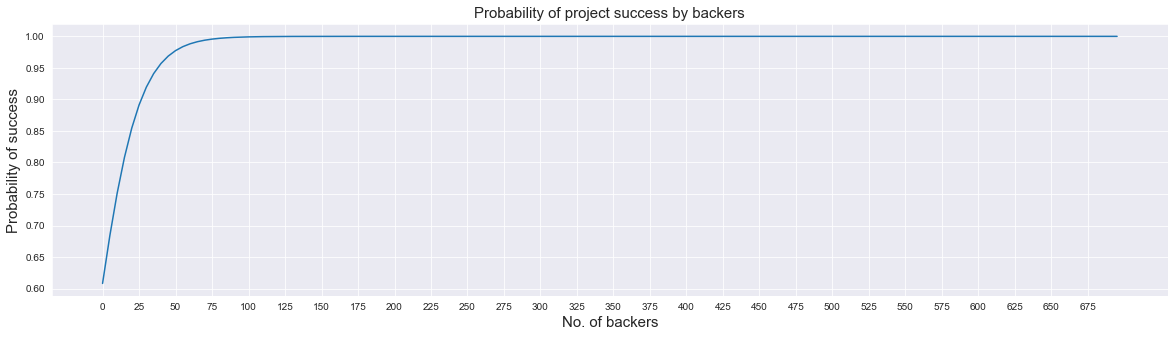

In [74]:
#Example of the function on some test data:

#Using the logistic regression model:

plot_success_graph(model = logmodel,
                   days = 50, 
                   goal = 10000, 
                   category = 'Games', 
                   country = 'NZ', 
                   max_backers = 700)

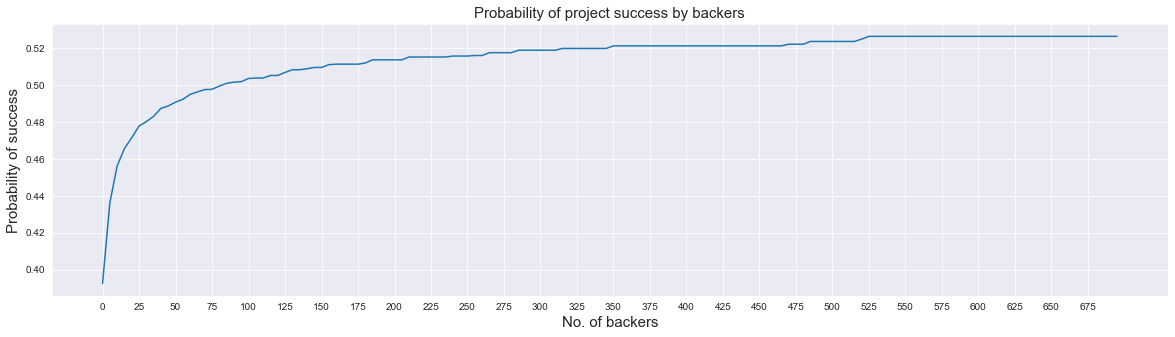

In [75]:
#Using the AdaBoost model:

plot_success_graph(model = adaboost_cv,
                   days = 50, 
                   goal = 10000, 
                   category = 'Games', 
                   country = 'NZ', 
                   max_backers = 700)

#Probabilities are alot more constrained below 0.5, is it because Adaboost predict_probas cannot be interpreted as probabilities?

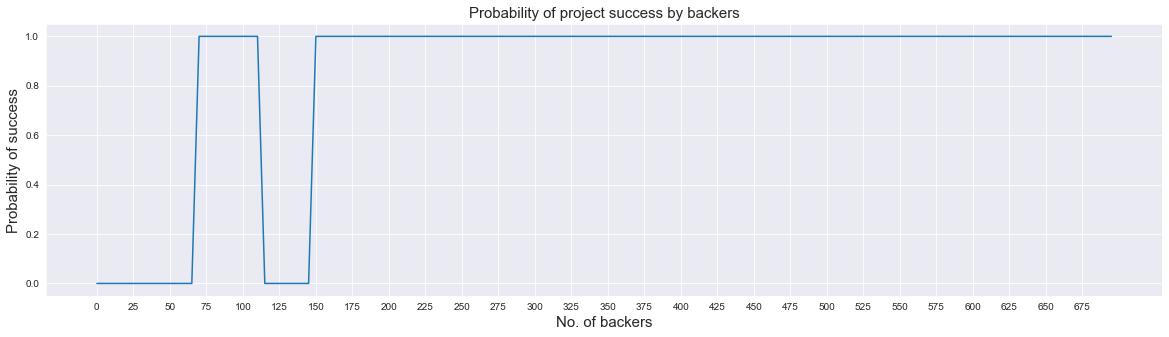

In [76]:
#Using the decision tree model:

plot_success_graph(model = tree,
                   days = 50, 
                   goal = 10000, 
                   category = 'Games', 
                   country = 'NZ', 
                   max_backers = 700)

#Even worse! The probabilities make no sense

### Observations:


All of the models don't seem to provide very believable probabilities with respect to the no. of backers a project might have, producing probabilities of above 0 even when the no. of backers is zero.

This could be due to the way predict_proba is calculated in sklearn models. Not all predict_proba scores in the models can be interpreted as true probabilities. Logistic Regression models produce outputs that are reasonable probabilities, but other models like Adaboost do not. We therefore have to calibrate the models to produce more realistic probability estimates.

### Trying to fix the issue by calibrating the predict_proba output of the AdaBoost model:

In [77]:
from sklearn.calibration import CalibratedClassifierCV


#Create model to calculate calibrated probabilities:

#calibrated_adaboost = CalibratedClassifierCV(base_estimator = adaboost_cv,
#                                             cv = None, #Default is 5-fold
#                                             method = 'isotonic', #Isotonic regression
#                                            )

#Fit calibrated model:

# calibrated_adaboost.fit(X_train,y_train) (Took 1 hour 16 min)

In [78]:
#Save calibrated model locally:

#joblib.dump(calibrated_adaboost, 'calibrated_adaboost_model.joblib')


#Load calibrated model:

calibrated_adaboost_cv = joblib.load('./Models/calibrated_adaboost_model.joblib')

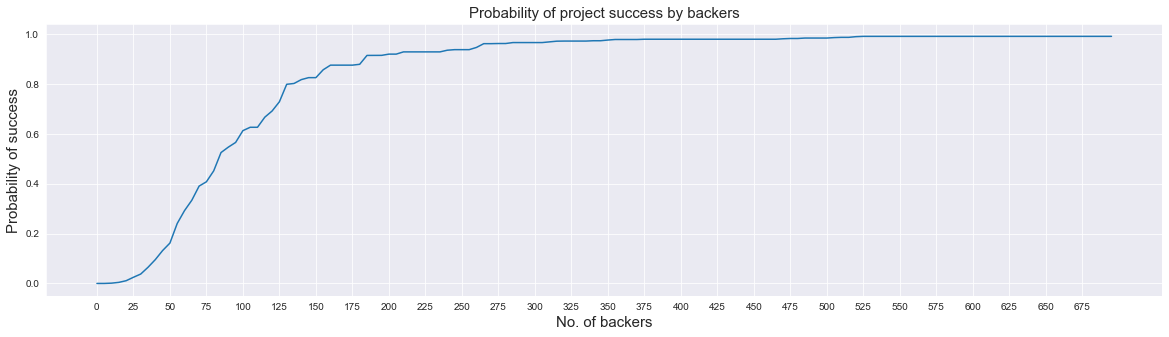

In [79]:
#Using the calibrated AdaBoost model:

plot_success_graph(model = calibrated_adaboost_cv,
                   days = 50, 
                   goal = 10000, 
                   category = 'Games', 
                   country = 'NZ', 
                   max_backers = 700)

#Probabilities are alot more constrained below 0.5, is it because Adaboost predict_probas cannot be interpreted as probabilities?

The calibrated model seems to produce a much more believable graph of probabilities!

# Conclusion:

The model will be useful for an entrepreneur looking for a rough estimate of how many backers a successful project would need. For example, an individual who is launching a game-related project in New Zealand with a goal of $10,000 and a deadline of 50 days would see from the above graph that he would need about 125+ backers to have a decent chance of success.

However, a big drawback of the models is that they don't take into account the backer contribution: For example, different projects can have different contribution amounts for each backer. Including such data in the kickstarter dataset would have been useful.